<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
Авторы материала: Data Science интерн Ciklum, студент магистерской программы CSDS UCU Виталий Радченко, программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Тема 5. Композиции алгоритмов, случайный лес</center>
## <center> Часть 2. Случайный лес</center>

Лео Брейман нашел применение бутстрэпу не только в статистике, но и в машинном обучении. Он вместе с Адель Катлер усовершенстовал алгоритм случайного леса, который был предложенный [Хо](http://ect.bell-labs.com/who/tkh/publications/papers/odt.pdf), добавив к первоначальному варианту построение некоррелируемых деревьев на основе CART, в сочетании с методом случайных подпространств и бэггинга. 

Решающие деревья являются хорошим семейством базовых классификаторов для бэггинга, поскольку они достаточно сложны и могут достигать нулевой ошибки на любой выборке. Метод случайных подпространств позволяет снизить коррелированность между деревьями и избежать переобучения. Базовые алгоритмы обучаются на различных подмножествах признакового описания, которые также выделяются случайным образом.
Ансамбль моделей, использующих метод случайного подпространства, можно построить, используя следующий алгоритм:
1. Пусть количество объектов для тренировки равно $\large N$, а количество признаков $\large D$.
2. Выберите $\large L$ как число отедельных моделей в ансамбле.
3. Для каждой отдельной модели $\large l$ выберите $\large dl (dl < D) $ как число признаков для $\large l$ . Обычно для всех моделей используется только одно значение $\large dl$.
4. Для каждой отдельной модели $\large l$ создайте обучающую выборку, выбрав $\large dl$-признаков из $\large D$ с заменой и обучите модель.

Теперь, чтобы применить модель ансамбля к новому объекту, объедините результаты отдельных $\large L$ моделей мажоритарным голосованием или путем комбинирования апостериорных вероятностей.


### Алгоритм

Алгоритм построения случайного леса, состоящего из $\large N$ деревьев, выглядит следующим образом:
* Для каждого $\large n = 1, \dots, N$:
     * Сгенерировать выборку $\large X_n$ с помощью bootstrap.
     * Построить решающее дерево $\large b_n$ по выборке $\large X_n$:
         — по заданному критерию мы выбираем лучший признак, делаем разбиение в дереве по нему и так до исчерпания выборки
         — дерево строится, пока в каждом листе не более $\large n_\text{min}$ объектов или пока не достигнем определенной высоты дерева
         — при каждом разбиении сначала выбирается $\large m$ случайных признаков из $\large n$ исходных, 
         и оптимальное разделение выборки ищется только среди них.
         
Итоговый классификатор $\large a(x) = \frac{1}{N}\sum_{i = 1}^N b_i(x)$, простыми словами — для задачи кассификации мы выбираем решение голосованием по большинству, а в задаче регрессии — средним.

Рекомендуется в задачах классификации брать $\large m = \sqrt{n}$, а в задачах регрессии — $\large m = \frac{n}{3}$, где $\large n$ — число признаков. Также рекомендуется в задачах классификации строить каждое дерево до тех пор, пока в каждом листе не окажется по одному объекту, а в задачах регрессии — пока в каждом листе не окажется по пять объектов.

Таким образом, случайный лес — это бэггинг над решающими деревьями, при обучении которых для каждого разбиения признаки выбираются из некоторого случайного подмножества признаков.

### Сравнение с деревом решений и бэггингом

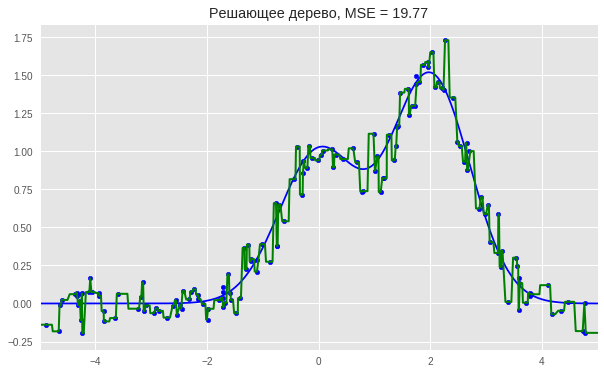

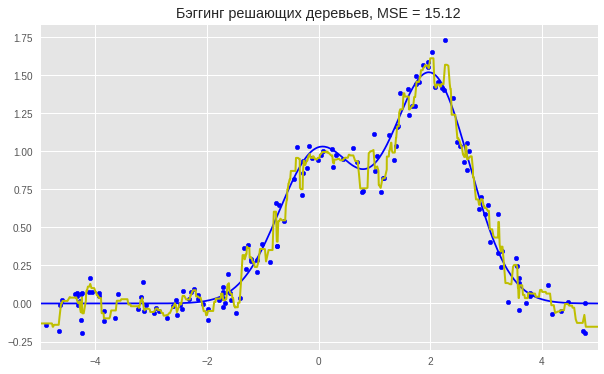

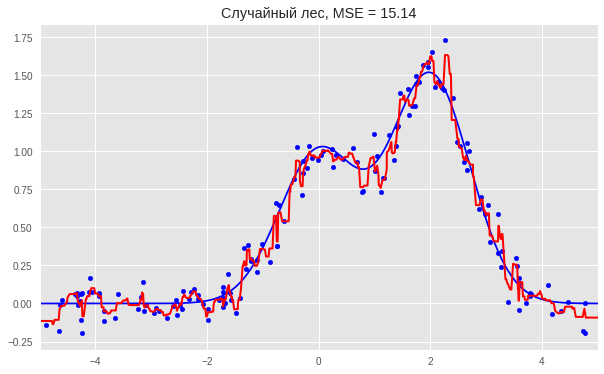

In [8]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
import numpy as np
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

     
n_train = 150        
n_test = 1000       
noise = 0.1

# Generate data
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2)\
        + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

# One decision tree regressor
dtree = DecisionTreeRegressor().fit(X_train, y_train)
d_predict = dtree.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, d_predict, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Решающее дерево, MSE = %.2f" 
          % np.sum((y_test - d_predict) ** 2))

# Bagging decision tree regressor
bdt = BaggingRegressor(DecisionTreeRegressor()).fit(X_train, y_train)
bdt_predict = bdt.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, bdt_predict, "y", lw=2)
plt.xlim([-5, 5])
plt.title("Бэггинг решающих деревьев, MSE = %.2f" % np.sum((y_test - bdt_predict) ** 2));

# Random Forest
rf = RandomForestRegressor(n_estimators=10).fit(X_train, y_train)
rf_predict = rf.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, rf_predict, "r", lw=2)
plt.xlim([-5, 5])
plt.title("Случайный лес, MSE = %.2f" % np.sum((y_test - rf_predict) ** 2));

Как мы видим из графиков и значений ошибки MSE, случайный лес из 10 деревьев дает лучший результат, чем одно дерево или бэггинг из 10 деревьев решений. Основное различие случайного леса и бэггинга на деревьях решений заключается в том, что в случайном лесе из случайного числа выбирается случайное подмножество признаков, и лучший признак для разделения узла определяется из подвыборки признаков, в отличие от бэггинга, где все функции рассматриваются для разделения в узле.

Также можно увидеть преимущество случайного леса и бэггинга в задачах классификации.



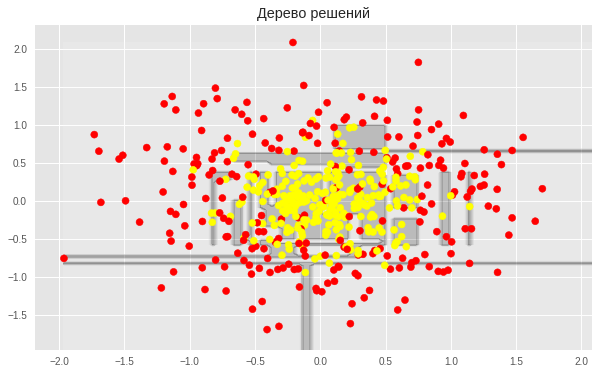

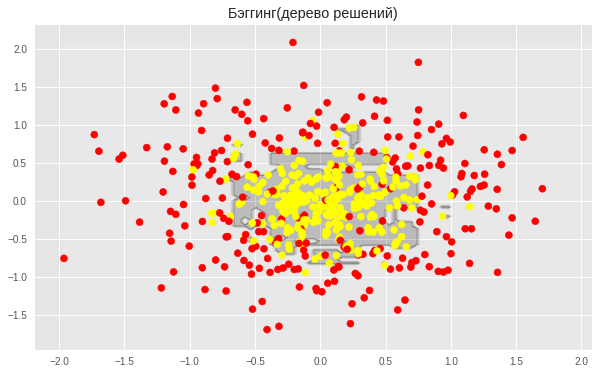

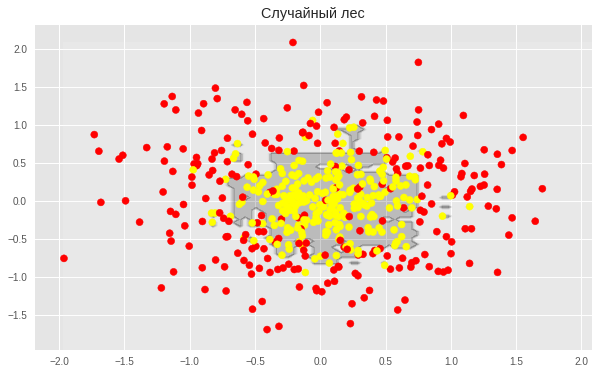

In [9]:
np.random.seed(42)
X, y = make_circles(n_samples=500, factor=0.1, noise=0.35, random_state=42)
X_train_circles, X_test_circles, y_train_circles, y_test_circles = train_test_split(X, y, test_size=0.2)

dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train_circles, y_train_circles)

x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)
y_hat = dtree.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Дерево решений")
plt.show()

b_dtree = BaggingClassifier(DecisionTreeClassifier(),n_estimators=300, random_state=42)
b_dtree.fit(X_train_circles, y_train_circles)

x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)
y_hat = b_dtree.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Бэггинг(дерево решений)")
plt.show()

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train_circles, y_train_circles)

x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)
y_hat = rf.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Случайный лес")
plt.show()

На рисунках выше видно, что разделяющая граница дерева решений очень «рваная» и на ней много острых углов, что говорит о переобучении и слабой обобщающей способности. В то время как у бэггинга и случайного леса граница достаточно сглаженная и практически нет признаков переобучения.

Давайте теперь попробуем разобраться с параметрами, с помощью подбора которых мы cможем увеличить долю правильных ответов.

### Параметры


Метод случайного леса реализован в библиотеке машинного обучения [scikit-learn](http://scikit-learn.org/stable/) двумя классами RandomForestClassifier и RandomForestRegressor.

Полный список параметров случайного леса для задачи регрессии:

```class sklearn.ensemble.RandomForestRegressor(
    n_estimators — число деревьев в "лесу" (по дефолту – 10)
    criterion — функция, которая измеряет качество разбиения ветки дерева (по дефолту — "mse" , так же можно выбрать "mae")
    max_features — число признаков, по которым ищется разбиение. Вы можете указать конкретное число или процент признаков, либо выбрать из доступных значений: "auto" (все признаки), "sqrt", "log2". По дефолту стоит "auto".
    max_depth — максимальная глубина дерева  (по дефолту глубина не ограничена)
    min_samples_split — минимальное количество объектов, необходимое для разделения внутреннего узла. Можно задать числом или процентом от общего числа объектов (по дефолту — 2)
    min_samples_leaf — минимальное число объектов в листе. Можно задать числом или процентом от общего числа объектов (по дефолту — 1)
    min_weight_fraction_leaf — минимальная взвешенная доля от общей суммы весов (всех входных объектов) должна быть в листе (по дефолту имеют одинаковый вес)
    max_leaf_nodes — максимальное количество листьев (по дефолту нет ограничения)
    min_impurity_split — порог для остановки наращивания дерева (по дефолту 1е-7)
    bootstrap — применять ли бустрэп для построения дерева (по дефолту True)
    oob_score — использовать ли out-of-bag объекты для оценки R^2 (по дефолту False)
    n_jobs — количество ядер для построения модели и предсказаний (по дефолту 1, если поставить -1, то будут использоваться все ядра)
    random_state — начальное значение для генерации случайных чисел (по дефолту его нет, если хотите воспроизводимые результаты, то нужно указать любое число типа int
    verbose — вывод логов по построению деревьев (по дефолту 0)
    warm_start — использует уже натренированую модель и добавляет деревьев в ансамбль (по дефолту False)
)```

Для задачи классификации все почти то же самое, мы приведем только те параметры, которыми RandomForestClassifier отличается от RandomForestRegressor 

```class sklearn.ensemble.RandomForestClassifier(
    criterion — поскольку у нас теперь задача классификации, то по дефолту выбран критерий "gini" (можно выбрать "entropy")
    class_weight — вес каждого класса (по дефолту все веса равны 1, но можно передать словарь с весами, либо явно указать "balanced", тогда веса классов будут равны их исходным частям в генеральной совокупности; также можно указать "balanced_subsample", тогда веса на каждой подвыборке будут меняться в зависимости от распределения классов на этой подвыборке.
```

Далее рассмотрим несколько параметров, на которые в первую очередь стоит обратить внимание при построении модели:
- n_estimators — число деревьев в "лесу"
- criterion — критерий для разбиения выборки в вершине
- max_features — число признаков, по которым ищется разбиение
- min_samples_leaf — минимальное число объектов в листе
- max_depth — максимальная глубина дерева

**Рассмотрим применение случайного леса в реальной задаче**

Для этого будем использовать пример с задачей fraud detection. Это задача классификации, поэтому будем использовать метрику accuracy для оценки точности. Для начала построим самый простой классификатор, который будет нашим бейслайном. Возьмем только числовые признаки для упрощения.


In [13]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score

# Загружаем данные
df = pd.read_csv("../../data/telecom_churn.csv")

# Выбираем сначала только колонки с числовым типом данных
cols = []
for i in df.columns:
    if (df[i].dtype == "float64") or (df[i].dtype == 'int64'):
        cols.append(i)
        
# Разделяем на признаки и объекты
X, y = df[cols].copy(), np.asarray(df["Churn"],dtype='int8')

# Инициализируем страифицированную разбивку нашего датасета для валидации
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Инициализируем наш классификатор с дефолтными параметрами
rfc = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)

# Обучаем на тренировочном датасете
results = cross_val_score(rfc, X, y, cv=skf)

# Оцениваем точность на тестовом датасете
print("CV accuracy score: {:.2f}%".format(results.mean()*100))

CV accuracy score: 91.48%


Получили точность 91.21%, теперь попробуем улучшить этот результат и посмотреть, как ведут себя кривые обучения при изменении основных параметров.

Начнем с количества деревьев:

In [14]:
# Инициализируем валидацию
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
trees_grid = [5, 10, 15, 20, 30, 50, 75, 100]

# Обучаем на тренировочном датасете
for ntrees in trees_grid:
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1, oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.44% with 50 trees


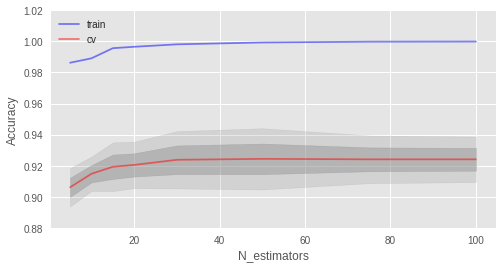

In [15]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators");

Как видно, при достижении определенного числа деревьев, наша точность на тесте выходит на асимптоту, и вы можете сами решить, сколько деревьев оптимально для вашей задачи. 
На рисунке также видно, что на тренировочной выборке мы смогли достичь 100% точности, это говорит нам о переобучении нашей модели. Чтобы избежать переобучения, мы должны добавить параметры регуляризации в модель.

Начнем с параметра максимальной глубины – `max_depth`. (зафиксируем к-во деревьев 100)

Best accuracy on CV is 92.68% with 17 max_depth


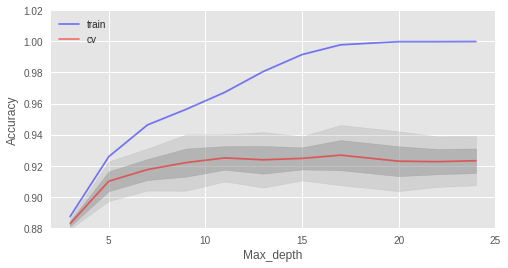

In [16]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_depth_grid = [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

# Обучаем на тренировочном датасете
for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True, max_depth=max_depth)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_depth".format(max(test_acc.mean(axis=1))*100, 
                                                        max_depth_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_depth");

Параметр `max_depth` хорошо справляется с регуляризацией модели, и мы уже не так сильно переобучаемся. Точность нашей модели немного возросла.

Еще важный параметр `min_samples_leaf`, он так же выполняет функцию регуляризатора.


In [17]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

# Обучаем на тренировочном датасете
for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                                 oob_score=True, min_samples_leaf=min_samples_leaf)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} min_samples_leaf".format(max(test_acc.mean(axis=1))*100, 
                                                        min_samples_leaf_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.41% with 3 min_samples_leaf


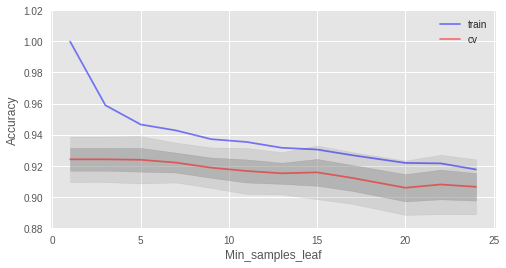

In [18]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Min_samples_leaf");

В данном случае мы не выигрываем в точности на валидации, но зато можем сильно уменьшить переобучение до 2% при сохранении точности около 92%.

Рассмотрим такой параметр как `max_features`. Для задач классификации по умолчанию используется $\large \sqrt{n}$, где n — число признаков. Давайте проверим, оптимально ли в нашем случае использовать 4 признака или нет.


Best accuracy on CV is 92.59% with 12 max_features


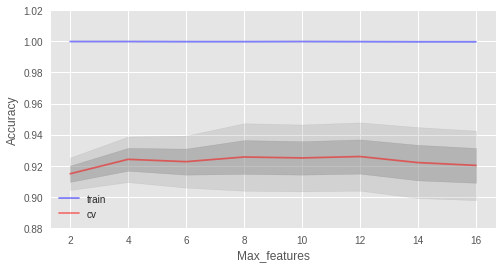

In [19]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_features_grid = [2, 4, 6, 8, 10, 12, 14, 16]

# Обучаем на тренировочном датасете
for max_features in max_features_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                                 oob_score=True, max_features=max_features)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_features".format(max(test_acc.mean(axis=1))*100, 
                                                        max_features_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_features_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_features");

В нашем случае оптимальное число признаков — 10, именно с таким значением достигается наилучший результат.

Мы рассмотрели, как ведут себя кривые обучения в зависимости от изменения основных параметров. Давайте теперь с помощью `GridSearch` найдем оптимальные параметры для нашего примера.


In [20]:
# Сделаем инициализацию параметров, по которым хотим сделать полный перебор
parameters = {'max_features': [4, 7, 10, 13], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5,10,15,20]}
rfc = RandomForestClassifier(n_estimators=100, random_state=42, 
                             n_jobs=-1, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X, y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  2.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [5, 10, 15, 20], 'min_samples_leaf': [1, 3, 5, 7], 'max_features': [4, 7, 10, 13]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [21]:
gcv.best_estimator_, gcv.best_score_

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=10, max_features=10, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
             oob_score=True, random_state=42, verbose=0, warm_start=False),
 0.92709270927092713)

Лучшая точность, который мы смогли достичь с помощью перебора параметров — 92.83% при `'max_depth': 15, 'max_features': 7, 'min_samples_leaf': 3`. 

### Вариация и декорреляционный эффект

Давайте запишем вариацию для случайного леса как $$ \large Varf(x) = \rho(x)\sigma^2(x) $$
Тут  
- $ \large \rho(x)$ – корреляция выборки между любыми двумя деревьями, используемыми при усреднении 
$$ \large \rho(x) = corr[T(x;\Theta_1(Z)),T(x_2,\Theta_2(Z))], $$ где $ \large \Theta_1(Z) $ и $ \large  \Theta_2(Z) $ – случайно выбранная пара деревьев на случайно выбранных объектах выборки Z
- $ \large \sigma^2(x)$ — это выборочная дисперсия любого произвольно выбранного дерева: $$ \large \sigma^2(x) = VarT(x;\Theta(X)$$

Легко спутать $ \large \rho(X) $ со средней корреляцией между обученными деревьями в данном случайном лесе, рассматривая деревья как N-векторы и вычисляя среднюю парную корреляцию между ними. Это не тот случай. Эта условная корреляция не имеет прямого отношения к процессу усреднения, а зависимость от  $ \large x$  в $ \large \rho(x)$ предупреждает нас об этом различии. Скорее, $ \large \rho(x)$ является теоретической корреляцией между парой случайных деревьев, оцененных в объекте $ \large x$, которая была вызвана многократным сэмплированием тренировочной выборки из генеральной совокупности $ \large Z $, и после этого выбрана данная пара случайных деревьев. На статистическом жаргоне это корреляция, вызванная выборочным распределением $ \large Z $ и $ \large \Theta $.

По факту, условная ковариация пары деревьев равна 0, потому что бустрэп и отбор признаков — независимы и одинаково распределены.

Если рассмотреть дисперсию по одному дереву, то она практически не меняется от переменных для разделения ($ \large m $), а вот для ансамбля это играет большую роль, и дисперсия для дерева намного выше, чем для ансамбля. 
В книге *The Elements of Statistical Learning (Trevor Hastie, Robert Tibshirani и Jerome Friedman)* есть отличный пример, который это демонстрирует.
![image](../../img/variance_rf.png)

### Смещение

Как и в бэггинге, смещение в случайном лесе такое же, как и смещение в отдельно взятом дереве $ \large T(x,\Theta(Z))$ 
$$ \large \begin{array}{rcl} Bias &=& \mu(x) - E_Zf_{rf}(x) \\
&=& \mu(x) - E_ZE_{\Theta | Z}T(x,\Theta(Z))\end{array}$$
Это также обычно больше (в абсолютных величинах), чем смещение «неусеченного» (unprunned) дерева, поскольку рандомизация и сокращение пространства выборки налагают ограничения. Следовательно, улучшения в прогнозировании, полученные с помощью бэггинга или случайных лесов, являются исключительно результатом уменьшения дисперсии.

###  Сверхслучайные деревья

В сверхслучайных деревьях (Extremely Randomized Trees) больше случайности в том, как вычисляются разделения в узлах. Как и в случайных лесах, используется случайное подмножество возможных признаков, но вместо поиска наиболее оптимальных порогов, пороговые значения произвольно выбираются для каждого возможного признака, и наилучший из этих случайно генерируемых порогов выбирается как лучшее правило для разделения узла. Это обычно позволяет немного уменьшить дисперсию модели за счет несколько большего увеличения смещения.

В библиотеке scikit-learn есть реализация [ExtraTreesClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier) и [ExtraTreesRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html#sklearn.ensemble.ExtraTreesRegressor). Данный метод стоит использовать, когда вы сильно переобучаетесь на случайном лесе или градиентном бустинге. 

### Схожесть случайного леса с алгоритмом k-ближайших соседей**

Метод случайного леса схож с методом ближайших соседей. Случайные леса, по сути, осуществляют предсказания для объектов на основе меток похожих объектов из обучения. Схожесть объектов при этом тем выше, чем чаще эти объекты оказываются в одном и том же листе дерева. Покажем это формально.

Рассмотрим задачу регрессии с квадратичной функцией потерь. Пусть $ \large T_n(x) $ — номер листа n-го дерева из случайного леса, в который попадает объект $ \large x $ . Ответ объекта $ \large x $ равен среднему ответу по всем объектам обучающей выборки, которые попали в этот лист $ \large T_n(x) $. Это можно записать так 
$$ \large b_n(x) = \sum_{i=1}^{l}w_n(x,x_i)y_i,$$ 
где $$ \large w_n(x, x_i) = \frac{[T_n(x) = T_n(x_i)]}{\sum_{j=1}^{l}[T_n(x) = T_n(x_j)]}$$
Тогда ответ композиции равен $$ \large \begin{array}{rcl} a_n(x) &=& \frac{1}{N}\sum_{n=1}^{N}\sum_{i=1}^{l}w_n(x,x_i)y_i \\
&=& \sum_{i=1}^{l}\Big(\frac{1}{N}\sum_{j=1}^{N}w_n(x,x_j)\Big)y_i \end{array}$$
Видно, что ответ случайного леса представляет собой сумму ответов всех объектов обучения с некоторыми весами. Отметим, что номер листа $ \large T_n(x)$, в который попал объект, сам по себе является ценным признаком. Достаточно неплохо работает подход, в котором по выборке обучается композиция из небольшого числа деревьев с помощью случайного леса или градиентного бустинга, а потом к ней добавляются категориальные признаки $ \large T_1(x), \dots, T_n(x) $. Новые признаки являются результатом нелинейного разбиения пространства и несут в себе информацию о сходстве объектов.

Все в той же книге *The Elements of Statistical Learning* есть хороший наглядный пример сходства случайного леса и k-ближайших соседей. 

![image](../../img/knn_vs_rf.png)

### Преобразование признаков в многомерное пространство

Все привыкли использовать случайный лес для задач обучения с учителем, но также есть возможность проводить обучение и без учителя. С помощью метода [RandomTreesEmbedding](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomTreesEmbedding.html#sklearn.ensemble.RandomTreesEmbedding) мы можем сделать трансформацию нашего датасета в многомерное разреженное его представление. Его суть в том, что мы строим абсолютно случайные деревья, и индекс листа, в котором оказалось наблюдение, мы считаем за новый признак. Если в первый лист попал объект, то мы ставим 1, а если не попал, то 0. Так называемое бинарное кодирование. Контролировать количество переменных и также степень разряженности нашего нового представления датасета мы можем увеличивая/уменьшая количество деревьев и их глубины. Поскольку соседние точки данных, скорее всего, лежат в одном и том же листе дерева, преобразование выполняет неявную, непараметрическую оценку плотности.



**Плюсы**:
 - имеет высокую точность предсказания, на большинстве задач будет лучше линейных алгоритмов; точность сравнима с точностью бустинга
 - практически не чувствителен к выбросам в данных из-за случайного сэмлирования
 - нечувствителен к масштабированию (и вообще к любым монотонным преобразованиям) значений признаков, связано с выбором случайных подпространств
 - не требует тщательной настройки параметров, хорошо работает «из коробки». С помощью «тюнинга» параметров можно достичь прироста от 0.5 до 3% точности в зависимости от задачи и данных
 - способен эффективно обрабатывать данные с большим числом признаков и классов
 - одинаково хорошо обрабатывет как непрерывные, так и дискретные признаки
 - редко переобучается, на практике добавление деревьев почти всегда только улучшает композицию, но на валидации, после достижения определенного количества деревьев, кривая обучения выходит на асимптоту
 - для случайного леса существуют методы оценивания значимости отдельных признаков в модели
 - хорошо работает с пропущенными данными; сохраняет хорошую точность, если большая часть данных пропущенна
 - предполагает возможность сбалансировать вес каждого класса на всей выборке, либо на подвыборке каждого дерева
 - вычисляет близость между парами объектов, которые могут использоваться при кластеризации, обнаружении выбросов или (путем масштабирования) дают интересные представления данных
 - возможности, описанные выше, могут быть расширены до немаркированных данных, что приводит к возможноти делать кластеризацию и визуализацию данных, обнаруживать выбросы
 - высокая параллелизуемость и масштабируемость.
 
**Минусы**:
 - в отличие от одного дерева, результаты случайного леса сложнее интерпретировать
 - нет формальных выводов (p-values), доступных для оценки важности переменных
 - алгоритм работает хуже многих линейных методов, когда в выборке очень много разреженных признаков (тексты, Bag of words)
 - случайный лес не умеет экстраполировать, в отличие от той же линейной регрессии (но это можно считать и плюсом, так как не будет экстремальных значений в случае попадания выброса)
 - алгоритм склонен к переобучению на некоторых задачах, особенно на зашумленных данных
 - для данных, включающих категориальные переменные с различным количеством уровней, случайные леса предвзяты в пользу признаков с большим количеством уровней: когда у признака много уровней, дерево будет сильнее подстраиваться именно под эти признаки, так как на них можно получить более высокую точность
 - если данные содержат группы коррелированных признаков, имеющих схожую значимость для меток, то предпочтение отдается небольшим группам перед большими
 - больший размер получающихся моделей. Требуется $inline$\large O(NK) $inline$ памяти для хранения модели, где $inline$\large K $inline$ — число деревьев.

**Полезные источники:**
- 15 раздел книги “[Elements of Statistical Learning](https://statweb.stanford.edu/~tibs/ElemStatLearn/)” Jerome H. Friedman, Robert Tibshirani, and Trevor Hastie
- [Блог](https://alexanderdyakonov.wordpress.com/2016/11/14/случайный-лес-random-forest/) Александра Дьяконова
- больше про практические применение случайного леса и других алгоритмов композиций в официальной документации [scikit-learn](http://scikit-learn.org/stable/modules/ensemble.html)
- [Курс](https://github.com/esokolov/ml-course-hse) Евгения Соколова по машинному обучению (материалы на GitHub). Есть дополнительные практические задания для углубления ваших знаний.